In [1]:
# !pip install --upgrade ta


In [2]:
from env import API_KEY
import pandas as pd,plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"
import sweetviz as sv
import plotly.express as px

from ta.trend import MACD as md
import pandas as pd
import ta
from ta.utils import dropna
import pycaret 


Obtaining Data

In [3]:
# Data Collection
from tiingo import TiingoClient
from datetime import datetime, timedelta

config = {
    'api_key': API_KEY,
    'session': True  # Use requests.Session
}
client = TiingoClient(config)

# Calculate the start date as today's date minus 2 years
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

# Convert dates to string format
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

df = client.get_dataframe('MSFT', frequency='daily',startDate=start_date_str, endDate=end_date_str)

df.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2019-02-28 00:00:00+00:00,112.03,112.88,111.73,112.04,29083934,106.623859,107.432842,106.338336,106.633377,29083934,0.0,1.0
2019-03-01 00:00:00+00:00,112.53,113.02,111.67,112.89,23501169,107.099731,107.566086,106.281232,107.442359,23501169,0.0,1.0
2019-03-04 00:00:00+00:00,112.26,113.25,110.80,113.02,26608014,106.842760,107.784987,105.453214,107.566086,26608014,0.0,1.0
2019-03-05 00:00:00+00:00,111.70,112.39,111.23,112.25,19538318,106.309784,106.966487,105.862464,106.833243,19538318,0.0,1.0
2019-03-06 00:00:00+00:00,111.75,112.66,111.43,111.87,17686996,106.357371,107.223458,106.052813,106.471580,17686996,0.0,1.0


In [4]:
df.reset_index(inplace=True)
df.rename(columns={'index': 'new_index'}, inplace=True)  # Rename the old index column
df['date'] = df['date'].dt.date  # Extract the date part from the datetime index
df

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2019-02-28,112.03,112.88,111.73,112.040,29083934,106.623859,107.432842,106.338336,106.633377,29083934,0.0,1.0
1,2019-03-01,112.53,113.02,111.67,112.890,23501169,107.099731,107.566086,106.281232,107.442359,23501169,0.0,1.0
2,2019-03-04,112.26,113.25,110.80,113.020,26608014,106.842760,107.784987,105.453214,107.566086,26608014,0.0,1.0
3,2019-03-05,111.70,112.39,111.23,112.250,19538318,106.309784,106.966487,105.862464,106.833243,19538318,0.0,1.0
4,2019-03-06,111.75,112.66,111.43,111.870,17686996,106.357371,107.223458,106.052813,106.471580,17686996,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-02-20,402.79,404.49,398.01,403.240,24307915,402.790000,404.490000,398.010000,403.240000,24307915,0.0,1.0
1253,2024-02-21,402.18,402.29,397.22,400.170,18631072,402.180000,402.290000,397.220000,400.170000,18631072,0.0,1.0
1254,2024-02-22,411.65,412.83,408.57,410.190,27009869,411.650000,412.830000,408.570000,410.190000,27009869,0.0,1.0
1255,2024-02-23,410.34,415.86,408.97,415.670,16295879,410.340000,415.860000,408.970000,415.670000,16295879,0.0,1.0


Removing Columns

In [5]:
# Removing 'Dividends' and 'Stock Splits' columns
df = df.drop(['divCash', 'splitFactor','close','high','low', 'open', 'volume','adjVolume'], axis = 1)
# See results
df

,date,adjClose,adjHigh,adjLow,adjOpen
0,2019-02-28,106.623859,107.432842,106.338336,106.633377
1,2019-03-01,107.099731,107.566086,106.281232,107.442359
2,2019-03-04,106.842760,107.784987,105.453214,107.566086
3,2019-03-05,106.309784,106.966487,105.862464,106.833243
4,2019-03-06,106.357371,107.223458,106.052813,106.471580
...,...,...,...,...,...
1252,2024-02-20,402.790000,404.490000,398.010000,403.240000
1253,2024-02-21,402.180000,402.290000,397.220000,400.170000
1254,2024-02-22,411.650000,412.830000,408.570000,410.190000
1255,2024-02-23,410.340000,415.860000,408.970000,415.670000


In [6]:
# Removing NaN
df.dropna(inplace=True)
# See Results
df

,date,adjClose,adjHigh,adjLow,adjOpen
0,2019-02-28,106.623859,107.432842,106.338336,106.633377
1,2019-03-01,107.099731,107.566086,106.281232,107.442359
2,2019-03-04,106.842760,107.784987,105.453214,107.566086
3,2019-03-05,106.309784,106.966487,105.862464,106.833243
4,2019-03-06,106.357371,107.223458,106.052813,106.471580
...,...,...,...,...,...
1252,2024-02-20,402.790000,404.490000,398.010000,403.240000
1253,2024-02-21,402.180000,402.290000,397.220000,400.170000
1254,2024-02-22,411.650000,412.830000,408.570000,410.190000
1255,2024-02-23,410.340000,415.860000,408.970000,415.670000


In [7]:

# Calculate the RSI using the adjusted close column
rsi_indicator = ta.momentum.RSIIndicator(close=df['adjOpen'], window=14)
df['RSI'] = rsi_indicator.rsi()


df_diff = df.drop(columns=['RSI']).diff().dropna()


diffs = pd.concat([df_diff, df[['RSI']]], axis=1)

# Display the resulting dataframe
diffs

,date,adjClose,adjHigh,adjLow,adjOpen,RSI
1,"1 day, 0:00:00",0.475872,0.133244,-0.057105,0.808982,NaN
2,"3 days, 0:00:00",-0.256971,0.218901,-0.828017,0.123727,NaN
3,"1 day, 0:00:00",-0.532977,-0.818500,0.409250,-0.732843,NaN
4,"1 day, 0:00:00",0.047587,0.256971,0.190349,-0.361663,NaN
5,"1 day, 0:00:00",-1.294372,-1.056436,-1.484720,-0.447320,NaN
...,...,...,...,...,...,...
1253,"1 day, 0:00:00",-0.610000,-2.200000,-0.790000,-3.070000,49.344387
1254,"1 day, 0:00:00",9.470000,10.540000,11.350000,10.020000,57.606315
1255,"1 day, 0:00:00",-1.310000,3.030000,0.400000,5.480000,61.321816
1256,"3 days, 0:00:00",-2.800000,-3.700000,-1.610000,-4.215000,57.171354


In [8]:
diffs.corr()

,adjClose,adjHigh,adjLow,adjOpen,RSI
adjClose,1.000000,0.688552,0.694616,0.283099,0.078935
adjHigh,0.688552,1.000000,0.719940,0.694127,0.238673
adjLow,0.694616,0.719940,1.000000,0.710514,0.216930
adjOpen,0.283099,0.694127,0.710514,1.000000,0.326066
RSI,0.078935,0.238673,0.216930,0.326066,1.000000


In [9]:

# Create a lag feature to represent the previous values
for i in range(1, 6):  # Assuming you want to use the first 15 points to predict the next one
    diffs[f'adjCloseLag_{i}'] = diffs['adjClose'].shift(i)
    diffs[f'adjHighlag_{i}'] = diffs['adjHigh'].shift(i)
    diffs[f'adjLowlag_{i}'] = diffs['adjLow'].shift(i)
    diffs[f'adjOpenlag_{i}'] = diffs['adjOpen'].shift(i)



In [10]:
diffs.head(10)

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,...,adjLowlag_3,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5
1,"1 day, 0:00:00",0.475872,0.133244,-0.057105,0.808982,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"3 days, 0:00:00",-0.256971,0.218901,-0.828017,0.123727,NaN,0.475872,0.133244,-0.057105,0.808982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"1 day, 0:00:00",-0.532977,-0.818500,0.409250,-0.732843,NaN,-0.256971,0.218901,-0.828017,0.123727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"1 day, 0:00:00",0.047587,0.256971,0.190349,-0.361663,NaN,-0.532977,-0.818500,0.409250,-0.732843,...,-0.057105,0.808982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"1 day, 0:00:00",-1.294372,-1.056436,-1.484720,-0.447320,NaN,0.047587,0.256971,0.190349,-0.361663,...,-0.828017,0.123727,0.475872,0.133244,-0.057105,0.808982,NaN,NaN,NaN,NaN
6,"1 day, 0:00:00",0.114209,-0.799465,-1.018366,-2.131906,NaN,-1.294372,-1.056436,-1.484720,-0.447320,...,0.409250,-0.732843,-0.256971,0.218901,-0.828017,0.123727,0.475872,0.133244,-0.057105,0.808982
7,"3 days, 0:00:00",2.208046,2.131906,2.074802,1.741691,NaN,0.114209,-0.799465,-1.018366,-2.131906,...,0.190349,-0.361663,-0.532977,-0.818500,0.409250,-0.732843,-0.256971,0.218901,-0.828017,0.123727
8,"1 day, 0:00:00",0.751878,0.989814,1.589412,1.741691,NaN,2.208046,2.131906,2.074802,1.741691,...,-1.484720,-0.447320,0.047587,0.256971,0.190349,-0.361663,-0.532977,-0.818500,0.409250,-0.732843
9,"1 day, 0:00:00",0.837535,0.961261,1.075471,1.246784,NaN,0.751878,0.989814,1.589412,1.741691,...,-1.018366,-2.131906,-1.294372,-1.056436,-1.484720,-0.447320,0.047587,0.256971,0.190349,-0.361663
10,"1 day, 0:00:00",0.085657,0.190349,0.523459,0.390215,NaN,0.837535,0.961261,1.075471,1.246784,...,2.074802,1.741691,0.114209,-0.799465,-1.018366,-2.131906,-1.294372,-1.056436,-1.484720,-0.447320


In [11]:
diffs['date'] = df['date']
diffs

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,...,adjLowlag_3,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5
1,2019-03-01,0.475872,0.133244,-0.057105,0.808982,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-03-04,-0.256971,0.218901,-0.828017,0.123727,NaN,0.475872,0.133244,-0.057105,0.808982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-03-05,-0.532977,-0.818500,0.409250,-0.732843,NaN,-0.256971,0.218901,-0.828017,0.123727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-03-06,0.047587,0.256971,0.190349,-0.361663,NaN,-0.532977,-0.818500,0.409250,-0.732843,...,-0.057105,0.808982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-03-07,-1.294372,-1.056436,-1.484720,-0.447320,NaN,0.047587,0.256971,0.190349,-0.361663,...,-0.828017,0.123727,0.475872,0.133244,-0.057105,0.808982,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-02-21,-0.610000,-2.200000,-0.790000,-3.070000,49.344387,-1.270000,-3.800000,-5.430000,-4.720000,...,-0.280000,0.070000,3.912833,0.518691,1.917477,3.870311,-8.923656,-10.649495,-11.339232,-15.586453
1254,2024-02-22,9.470000,10.540000,11.350000,10.020000,57.606315,-0.610000,-2.200000,-0.790000,-3.070000,...,-0.850000,-0.180000,-2.930000,-0.710000,-0.280000,0.070000,3.912833,0.518691,1.917477,3.870311
1255,2024-02-23,-1.310000,3.030000,0.400000,5.480000,61.321816,9.470000,10.540000,11.350000,10.020000,...,-5.430000,-4.720000,-2.500000,-0.840000,-0.850000,-0.180000,-2.930000,-0.710000,-0.280000,0.070000
1256,2024-02-26,-2.800000,-3.700000,-1.610000,-4.215000,57.171354,-1.310000,3.030000,0.400000,5.480000,...,-0.790000,-3.070000,-1.270000,-3.800000,-5.430000,-4.720000,-2.500000,-0.840000,-0.850000,-0.180000


In [12]:
diffs = diffs.drop(0)
diffs

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,...,adjLowlag_3,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5
1,2019-03-01,0.475872,0.133244,-0.057105,0.808982,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-03-04,-0.256971,0.218901,-0.828017,0.123727,NaN,0.475872,0.133244,-0.057105,0.808982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-03-05,-0.532977,-0.818500,0.409250,-0.732843,NaN,-0.256971,0.218901,-0.828017,0.123727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-03-06,0.047587,0.256971,0.190349,-0.361663,NaN,-0.532977,-0.818500,0.409250,-0.732843,...,-0.057105,0.808982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-03-07,-1.294372,-1.056436,-1.484720,-0.447320,NaN,0.047587,0.256971,0.190349,-0.361663,...,-0.828017,0.123727,0.475872,0.133244,-0.057105,0.808982,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-02-20,-1.270000,-3.800000,-5.430000,-4.720000,52.240910,-2.500000,-0.840000,-0.850000,-0.180000,...,1.917477,3.870311,-8.923656,-10.649495,-11.339232,-15.586453,-5.280329,-0.079854,-0.339378,5.295301
1253,2024-02-21,-0.610000,-2.200000,-0.790000,-3.070000,49.344387,-1.270000,-3.800000,-5.430000,-4.720000,...,-0.280000,0.070000,3.912833,0.518691,1.917477,3.870311,-8.923656,-10.649495,-11.339232,-15.586453
1254,2024-02-22,9.470000,10.540000,11.350000,10.020000,57.606315,-0.610000,-2.200000,-0.790000,-3.070000,...,-0.850000,-0.180000,-2.930000,-0.710000,-0.280000,0.070000,3.912833,0.518691,1.917477,3.870311
1255,2024-02-23,-1.310000,3.030000,0.400000,5.480000,61.321816,9.470000,10.540000,11.350000,10.020000,...,-5.430000,-4.720000,-2.500000,-0.840000,-0.850000,-0.180000,-2.930000,-0.710000,-0.280000,0.070000


In [13]:
diffs.dropna()

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,...,adjLowlag_3,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5
13,2019-03-19,0.076140,0.789947,0.894639,1.827348,77.738442,1.579895,0.342628,1.389546,0.789947,...,0.523459,0.390215,0.837535,0.961261,1.075471,1.246784,0.751878,0.989814,1.589412,1.741691
14,2019-03-20,-0.123727,0.295041,-0.266488,-0.666221,72.122497,0.076140,0.789947,0.894639,1.827348,...,0.247453,0.761395,0.085657,0.190349,0.523459,0.390215,0.837535,0.961261,1.075471,1.246784
15,2019-03-21,2.569708,1.970110,0.361663,-0.237936,70.172733,-0.123727,0.295041,-0.266488,-0.666221,...,1.389546,0.789947,1.256302,1.951075,0.247453,0.761395,0.085657,0.190349,0.523459,0.390215
16,2019-03-22,-3.017028,-1.170645,-0.047587,2.246115,76.602990,2.569708,1.970110,0.361663,-0.237936,...,0.894639,1.827348,1.579895,0.342628,1.389546,0.789947,1.256302,1.951075,0.247453,0.761395
17,2019-03-25,0.580564,-1.503755,-0.685256,-2.798127,59.417888,-3.017028,-1.170645,-0.047587,2.246115,...,-0.266488,-0.666221,0.076140,0.789947,0.894639,1.827348,1.579895,0.342628,1.389546,0.789947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-02-20,-1.270000,-3.800000,-5.430000,-4.720000,52.240910,-2.500000,-0.840000,-0.850000,-0.180000,...,1.917477,3.870311,-8.923656,-10.649495,-11.339232,-15.586453,-5.280329,-0.079854,-0.339378,5.295301
1253,2024-02-21,-0.610000,-2.200000,-0.790000,-3.070000,49.344387,-1.270000,-3.800000,-5.430000,-4.720000,...,-0.280000,0.070000,3.912833,0.518691,1.917477,3.870311,-8.923656,-10.649495,-11.339232,-15.586453
1254,2024-02-22,9.470000,10.540000,11.350000,10.020000,57.606315,-0.610000,-2.200000,-0.790000,-3.070000,...,-0.850000,-0.180000,-2.930000,-0.710000,-0.280000,0.070000,3.912833,0.518691,1.917477,3.870311
1255,2024-02-23,-1.310000,3.030000,0.400000,5.480000,61.321816,9.470000,10.540000,11.350000,10.020000,...,-5.430000,-4.720000,-2.500000,-0.840000,-0.850000,-0.180000,-2.930000,-0.710000,-0.280000,0.070000


In [14]:
import numpy as np
diffs['target'] =np.where(diffs.adjClose >=0 ,1,0 )
diffs.head()
diffs.dropna(inplace=True)
diffs.head()

,date,adjClose,adjHigh,adjLow,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,...,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5,target
13,2019-03-19,0.076140,0.789947,0.894639,1.827348,77.738442,1.579895,0.342628,1.389546,0.789947,...,0.390215,0.837535,0.961261,1.075471,1.246784,0.751878,0.989814,1.589412,1.741691,1
14,2019-03-20,-0.123727,0.295041,-0.266488,-0.666221,72.122497,0.076140,0.789947,0.894639,1.827348,...,0.761395,0.085657,0.190349,0.523459,0.390215,0.837535,0.961261,1.075471,1.246784,0
15,2019-03-21,2.569708,1.970110,0.361663,-0.237936,70.172733,-0.123727,0.295041,-0.266488,-0.666221,...,0.789947,1.256302,1.951075,0.247453,0.761395,0.085657,0.190349,0.523459,0.390215,1
16,2019-03-22,-3.017028,-1.170645,-0.047587,2.246115,76.602990,2.569708,1.970110,0.361663,-0.237936,...,1.827348,1.579895,0.342628,1.389546,0.789947,1.256302,1.951075,0.247453,0.761395,0
17,2019-03-25,0.580564,-1.503755,-0.685256,-2.798127,59.417888,-3.017028,-1.170645,-0.047587,2.246115,...,-0.666221,0.076140,0.789947,0.894639,1.827348,1.579895,0.342628,1.389546,0.789947,1


In [15]:
diffs.drop(['adjHigh', 'adjLow'],axis=1,inplace=True)
diffs.head()


,date,adjClose,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,adjCloseLag_2,adjHighlag_2,...,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5,target
13,2019-03-19,0.076140,1.827348,77.738442,1.579895,0.342628,1.389546,0.789947,1.256302,1.951075,...,0.390215,0.837535,0.961261,1.075471,1.246784,0.751878,0.989814,1.589412,1.741691,1
14,2019-03-20,-0.123727,-0.666221,72.122497,0.076140,0.789947,0.894639,1.827348,1.579895,0.342628,...,0.761395,0.085657,0.190349,0.523459,0.390215,0.837535,0.961261,1.075471,1.246784,0
15,2019-03-21,2.569708,-0.237936,70.172733,-0.123727,0.295041,-0.266488,-0.666221,0.076140,0.789947,...,0.789947,1.256302,1.951075,0.247453,0.761395,0.085657,0.190349,0.523459,0.390215,1
16,2019-03-22,-3.017028,2.246115,76.602990,2.569708,1.970110,0.361663,-0.237936,-0.123727,0.295041,...,1.827348,1.579895,0.342628,1.389546,0.789947,1.256302,1.951075,0.247453,0.761395,0
17,2019-03-25,0.580564,-2.798127,59.417888,-3.017028,-1.170645,-0.047587,2.246115,2.569708,1.970110,...,-0.666221,0.076140,0.789947,0.894639,1.827348,1.579895,0.342628,1.389546,0.789947,1


In [16]:
diffs.dropna(inplace=True)
diffs.head()

,date,adjClose,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,adjCloseLag_2,adjHighlag_2,...,adjOpenlag_3,adjCloseLag_4,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5,target
13,2019-03-19,0.076140,1.827348,77.738442,1.579895,0.342628,1.389546,0.789947,1.256302,1.951075,...,0.390215,0.837535,0.961261,1.075471,1.246784,0.751878,0.989814,1.589412,1.741691,1
14,2019-03-20,-0.123727,-0.666221,72.122497,0.076140,0.789947,0.894639,1.827348,1.579895,0.342628,...,0.761395,0.085657,0.190349,0.523459,0.390215,0.837535,0.961261,1.075471,1.246784,0
15,2019-03-21,2.569708,-0.237936,70.172733,-0.123727,0.295041,-0.266488,-0.666221,0.076140,0.789947,...,0.789947,1.256302,1.951075,0.247453,0.761395,0.085657,0.190349,0.523459,0.390215,1
16,2019-03-22,-3.017028,2.246115,76.602990,2.569708,1.970110,0.361663,-0.237936,-0.123727,0.295041,...,1.827348,1.579895,0.342628,1.389546,0.789947,1.256302,1.951075,0.247453,0.761395,0
17,2019-03-25,0.580564,-2.798127,59.417888,-3.017028,-1.170645,-0.047587,2.246115,2.569708,1.970110,...,-0.666221,0.076140,0.789947,0.894639,1.827348,1.579895,0.342628,1.389546,0.789947,1


In [17]:
from pycaret.classification import *
s = setup(diffs, target='target', fold_strategy='timeseries', ignore_features= ['adjClose', 'date', 'RSI'],session_id=123)



,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(1244, 25)"
4,Transformed data shape,"(1244, 22)"
5,Transformed train set shape,"(870, 22)"
6,Transformed test set shape,"(374, 22)"
7,Ignore features,3
8,Numeric features,21
9,Preprocess,True


In [18]:
#  Obtaining top 5 best models
top5 = compare_models(n_select=5)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6063,0.6457,0.7566,0.6059,0.6711,0.1884,0.1976,1.8390
ridge,Ridge Classifier,0.6025,0.0000,0.7716,0.6005,0.6736,0.1798,0.1913,0.2880
lda,Linear Discriminant Analysis,0.6025,0.6409,0.7665,0.6012,0.6721,0.1814,0.1917,0.3370
svm,SVM - Linear Kernel,0.5671,0.0000,0.6423,0.5842,0.6105,0.1177,0.1189,0.3190
xgboost,Extreme Gradient Boosting,0.5481,0.5530,0.6530,0.5628,0.6026,0.0793,0.0828,0.3290
dt,Decision Tree Classifier,0.5443,0.5413,0.5737,0.5706,0.5710,0.0816,0.0821,0.2850
gbc,Gradient Boosting Classifier,0.5380,0.5383,0.6795,0.5563,0.6081,0.0628,0.0682,0.3420
rf,Random Forest Classifier,0.5342,0.5240,0.6880,0.5510,0.6092,0.0492,0.0531,0.4340
qda,Quadratic Discriminant Analysis,0.5329,0.5285,0.6624,0.5518,0.6002,0.0476,0.0482,0.2860
lightgbm,Light Gradient Boosting Machine,0.5329,0.5374,0.6307,0.5532,0.5879,0.0478,0.0496,0.3270


In [19]:
# Create model
lr = create_model('lr')



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6076,0.5312,0.8085,0.6333,0.7103,0.1294,0.1390
1,0.6456,0.7067,0.7442,0.6531,0.6957,0.2757,0.2791
2,0.5949,0.6006,0.8182,0.6000,0.6923,0.1390,0.1540
3,0.4937,0.4852,0.6905,0.5179,0.5918,-0.0402,-0.0431
4,0.5443,0.5727,0.6667,0.5600,0.6087,0.0730,0.0746
5,0.6962,0.8043,0.9091,0.5882,0.7143,0.4202,0.4666
6,0.5443,0.6436,0.6750,0.5400,0.6000,0.0855,0.0884
7,0.6835,0.7760,0.7805,0.6667,0.7191,0.3619,0.3678
8,0.5696,0.6333,0.6735,0.6471,0.6600,0.0744,0.0745


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
#Tune model
tuned_lr = tune_model(lr,optimize='AUC')
# tuned_lda = tune_model(lda, optimize='AUC')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [21]:
# Evaluate the model
evaluate_model(tuned_lr)
# interpret_model(lda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [22]:
dashboard(tuned_lr,display_format='inline')

Note: model_output='probability' is currently not supported for linear classifiers models with shap. So defaulting to model_output='logodds' If you really need probability outputs use shap='kernel' instead.
Note: shap values for shap='linear' get calculated against X_background, but paramater X_background=None, so using X instead...
Generating self.shap_explainer = shap.LinearExplainer(model, X)...
Building ExplainerDashboard..
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calc

In [23]:
final_lr_model = finalize_model(tuned_lr)


In [24]:
save_model(final_lr_model,model_name='final_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\shubh\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['adjOpen', 'adjCloseLag_1',
                                              'adjHighlag_1', 'adjLowlag_1',
                                              'adjOpenlag_1', 'adjCloseLag_2',
                                              'adjHighlag_2', 'adjLowlag_2',
                                              'adjOpenlag_2', 'adjCloseLag_3',
                                              'adjHighlag_3', 'adjLowlag_3',
                                              'adjOpenlag_3', 'adjCloseLag_...
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='most_frequent',
                          

In [25]:
predictions = predict_model(final_lr_model,
                          data =diffs)
predictions.head(5)

,date,adjClose,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,adjCloseLag_2,adjHighlag_2,...,adjHighlag_4,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5,target,prediction_label,prediction_score
13,2019-03-19,0.076140,1.827348,77.738441,1.579895,0.342628,1.389546,0.789947,1.256302,1.951075,...,0.961261,1.075471,1.246784,0.751878,0.989814,1.589412,1.741691,1,1,0.5452
14,2019-03-20,-0.123727,-0.666221,72.122498,0.076140,0.789947,0.894639,1.827348,1.579895,0.342628,...,0.190349,0.523459,0.390215,0.837535,0.961261,1.075471,1.246784,0,0,0.5206
15,2019-03-21,2.569708,-0.237936,70.172729,-0.123727,0.295041,-0.266488,-0.666221,0.076140,0.789947,...,1.951075,0.247453,0.761395,0.085657,0.190349,0.523459,0.390215,1,0,0.5565
16,2019-03-22,-3.017028,2.246115,76.602989,2.569708,1.970110,0.361663,-0.237936,-0.123727,0.295041,...,0.342628,1.389546,0.789947,1.256302,1.951075,0.247453,0.761395,0,0,0.5407
17,2019-03-25,0.580564,-2.798127,59.417889,-3.017028,-1.170645,-0.047587,2.246115,2.569708,1.970110,...,0.789947,0.894639,1.827348,1.579895,0.342628,1.389546,0.789947,1,0,0.5092


In [26]:
# Create a new column 'Profit_Loss' and calculate cumulative total
predictions['Profit_Loss'] = 0  # Initialize the column with zeros
cumulative_total = 0  # Initialize cumulative total


predictions.Profit_Loss = np.where((predictions.prediction_label == 1) & (predictions.adjClose > 0),1,-1)
predictions.Profit_Loss = np.where((predictions.prediction_label == 0) & (predictions.adjClose < 0),1,-1)

# Display the updated DataFrame
predictions.head()

,date,adjClose,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,adjCloseLag_2,adjHighlag_2,...,adjLowlag_4,adjOpenlag_4,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5,target,prediction_label,prediction_score,Profit_Loss
13,2019-03-19,0.076140,1.827348,77.738441,1.579895,0.342628,1.389546,0.789947,1.256302,1.951075,...,1.075471,1.246784,0.751878,0.989814,1.589412,1.741691,1,1,0.5452,-1
14,2019-03-20,-0.123727,-0.666221,72.122498,0.076140,0.789947,0.894639,1.827348,1.579895,0.342628,...,0.523459,0.390215,0.837535,0.961261,1.075471,1.246784,0,0,0.5206,1
15,2019-03-21,2.569708,-0.237936,70.172729,-0.123727,0.295041,-0.266488,-0.666221,0.076140,0.789947,...,0.247453,0.761395,0.085657,0.190349,0.523459,0.390215,1,0,0.5565,-1
16,2019-03-22,-3.017028,2.246115,76.602989,2.569708,1.970110,0.361663,-0.237936,-0.123727,0.295041,...,1.389546,0.789947,1.256302,1.951075,0.247453,0.761395,0,0,0.5407,1
17,2019-03-25,0.580564,-2.798127,59.417889,-3.017028,-1.170645,-0.047587,2.246115,2.569708,1.970110,...,0.894639,1.827348,1.579895,0.342628,1.389546,0.789947,1,0,0.5092,-1


In [27]:
predictions['Loss_Gain'] = predictions.adjClose.abs() * predictions.Profit_Loss

predictions['Cumulative_Total'] = predictions['Loss_Gain'].cumsum()
predictions.tail(6)

,date,adjClose,adjOpen,RSI,adjCloseLag_1,adjHighlag_1,adjLowlag_1,adjOpenlag_1,adjCloseLag_2,adjHighlag_2,...,adjCloseLag_5,adjHighlag_5,adjLowlag_5,adjOpenlag_5,target,prediction_label,prediction_score,Profit_Loss,Loss_Gain,Cumulative_Total
1251,2024-02-16,-2.50,-0.180,57.019279,-2.93,-0.71,-0.28,0.07,3.912833,0.518691,...,6.428226,5.250384,2.555320,1.197806,0,1,0.6378,-1,-2.50,-1160.265149
1252,2024-02-20,-1.27,-4.720,52.240910,-2.50,-0.84,-0.85,-0.18,-2.930000,-0.710000,...,-5.280329,-0.079854,-0.339378,5.295301,0,1,0.5543,-1,-1.27,-1161.535149
1253,2024-02-21,-0.61,-3.070,49.344387,-1.27,-3.80,-5.43,-4.72,-2.500000,-0.840000,...,-8.923656,-10.649495,-11.339231,-15.586452,0,0,0.6420,1,0.61,-1160.925149
1254,2024-02-22,9.47,10.020,57.606316,-0.61,-2.20,-0.79,-3.07,-1.270000,-3.800000,...,3.912833,0.518691,1.917477,3.870311,1,1,0.9572,-1,-9.47,-1170.395149
1255,2024-02-23,-1.31,5.480,61.321815,9.47,10.54,11.35,10.02,-0.610000,-2.200000,...,-2.930000,-0.710000,-0.280000,0.070000,0,1,0.7419,-1,-1.31,-1171.705149
1256,2024-02-26,-2.80,-4.215,57.171356,-1.31,3.03,0.40,5.48,9.470000,10.540000,...,-2.500000,-0.840000,-0.850000,-0.180000,0,0,0.5618,1,2.80,-1168.905149


<AxesSubplot: >

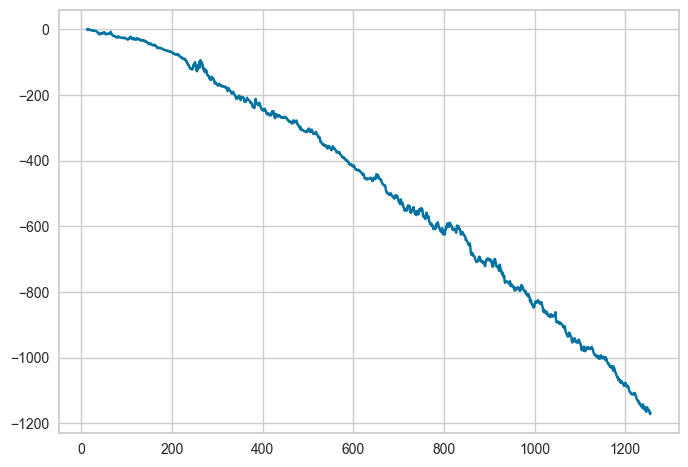

In [28]:
predictions.Cumulative_Total.plot()

In [29]:



# Create and tune a decision tree model
dt = create_model('dt')


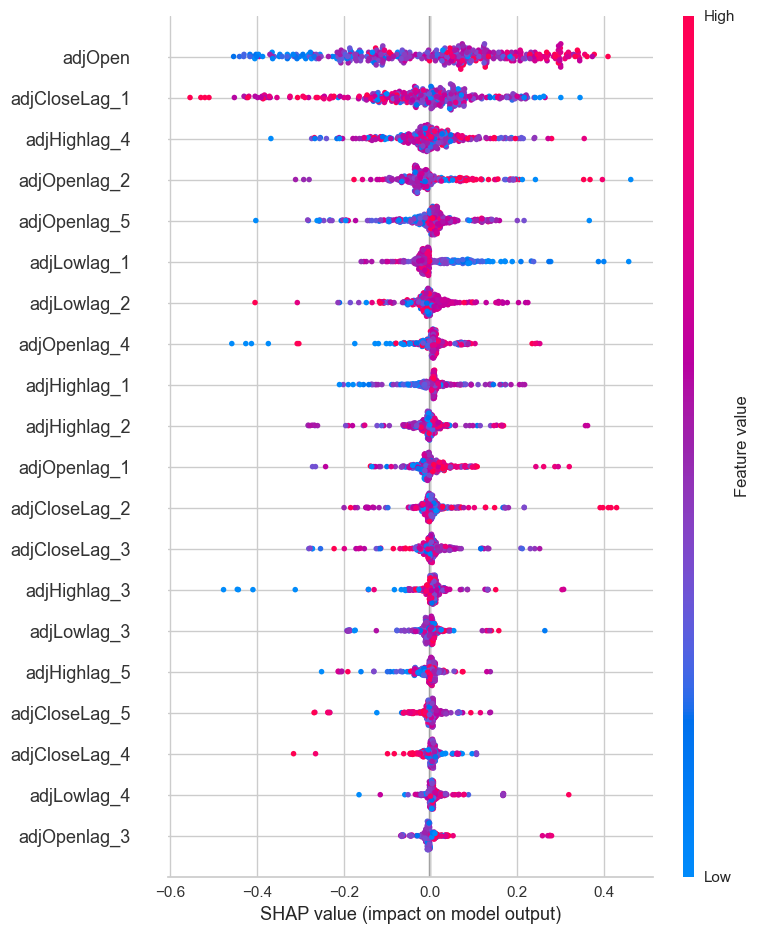

In [31]:
interpret_model(dt)

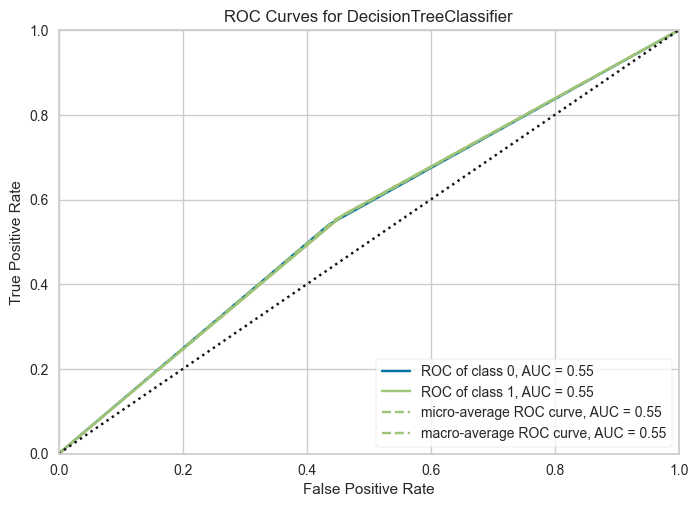

In [30]:
plot_model(dt, plot='auc')